Actions received by class: 5
state agents 0: [[0, 0], False, None]
Physical action taken 0:  4
state agents 1: [[4, 0], False, None]
Physical action taken 1:  1
win status agent 0 = False
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent0 not hit !!!!!
Reward for agent 0: -1
next state for agent 0: [[1, 0], False, ['Message send from agent 1']]
agent1 not hit !!!!!
Reward for agent 1: -1
next state for agent 1: [[4, 0], False, ['Message send from agent 0']]
state agents 0: [[1, 0], False, ['Message send from agent 1']]
Physical action taken 0:  3
state agents 1: [[4, 0], False, ['Message send from agent 0']]
Physical action taken 1:  2
win status agent 0 = False
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent0 not hit !!!!!
Reward for agent 0: -1
next state for agent 0: [[0, 0], False, ['Message send from agent 1']]
agent1 not hit !!!!!
Reward for agent 1: -10
next state for agent 1: [[4, 1], False,

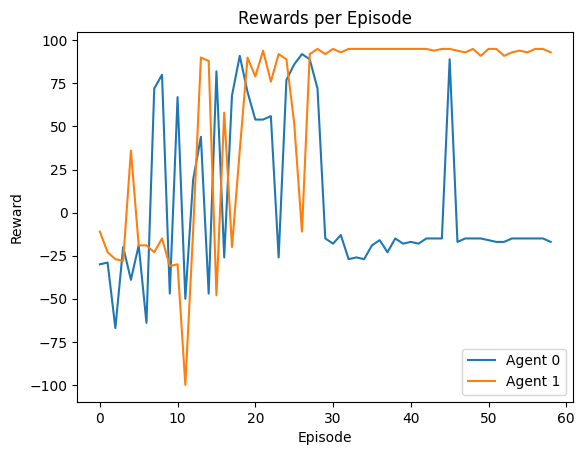

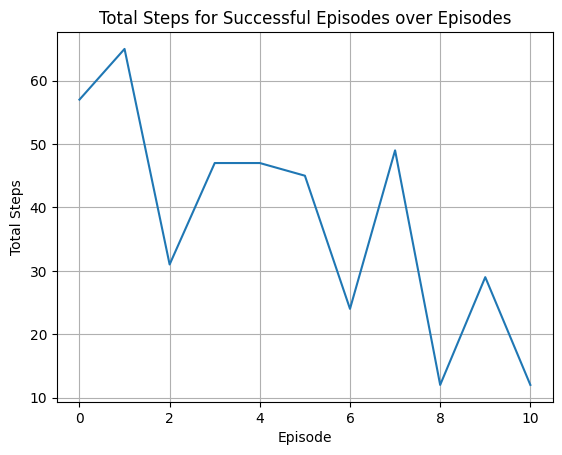

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from environment_ma_reward_distance_dynamic import Env

class QLearningAgent:
    def __init__(self, env, actions):
        print(f"Actions received by class: {actions}")
        self.env = env
        self.actions = actions
        self.learning_rate = 0.1  
        self.discount_factor = 0.9
        self.epsilon = 0.1  
        self.epsilon_decay = 0.995  
        self.epsilon_min = 0.01  
        self.q_tables = [defaultdict(lambda: [0.0] * actions) for _ in range(env.num_agents)]
        self.rewards_per_episode = [[] for _ in range(env.num_agents)] 
        self.successful_episodes = [0] * env.num_agents  
        self.total_successful_episodes = 0  # 

    def learn(self, agent_idx, state, physical_action, reward, next_state, comm_action):
        # print(f"state agents type received by Learn function{agent_idx}: {state}")
        # print(f"state agents type received by Learn function{agent_idx}: {type(state)}")
        
        physical_state = tuple(state[0])
        winning_state = state[1]
        comm_state = state[2]

        physical_next_state = tuple(next_state[0])
        winning_next_state = next_state[1]
        comm_next_state = next_state[2]

        # print(f"state agents {agent_idx} in Learning process: {state}")
        # print(f"next state agents {agent_idx} in Learning process: {next_state}")

        # print(f"physical state agents type received by Learn function{agent_idx}: {physical_state}")
        # print(f"physical state agents type received by Learn function{agent_idx}: {type(physical_state)}")

        # print(f"physical Next state agents type received by Learn function{agent_idx}: {physical_next_state}")
        # print(f"physical Next state agents type received by Learn function{agent_idx}: {type(physical_next_state)}")

        current_q = self.q_tables[agent_idx][physical_state][physical_action]
        # print(f"current q on {agent_idx} - {physical_state} - {physical_action}: {current_q}")
        max_next_q = max(self.q_tables[agent_idx][physical_next_state])
        # print(f"next q on {agent_idx} - {physical_next_state} - {self.q_tables[agent_idx][physical_next_state]}")
        new_q = (current_q + self.learning_rate *
                (reward + self.discount_factor * max_next_q - current_q))
        self.q_tables[agent_idx][physical_state][physical_action] = new_q

        # Update q-table with communication action if it's not None
        # if comm_action is not None:
        #     print(f"Agent {agent_idx} sends message: {comm_action}")

    def print_q_table(self, agent_id):
        print(f"Q-table for Agent {agent_id}:")
        for state, actions in self.q_tables[agent_id].items():
            print(f"  State: {state}")
            for action, q_value in enumerate(actions):
                print(f"    Action: {action}, Q-value: {q_value:.5f}")
        print(f"End of Q-table for Agent {agent_id}\n")

    def get_action(self, agent_idx, state):
        # print(f"state agents received by get action function{agent_idx}: {state}")
        # print(f"state agents type received by get action function{agent_idx}: {type(state)}")
        physical_state = tuple(state[0])
        winning_state = state[1]
        comm_state = state[2]
        # print(f"physical state agents received by get action function{agent_idx}: {physical_state}")
        # print(f"physical state agents type received by get action function{agent_idx}: {type(physical_state)}")

        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
            # print(f"action taken from random function by agent {agent_idx} in state {physical_state}: {action}")
            # print(f"self action value: {self.actions}")
            # print(f"len action probability: {self.actions}")
            # print(f"action taken random: {action}")
        else:
            state_action = self.q_tables[agent_idx][physical_state]
            # print(f"state action of agent {agent_idx} in state {physical_state}: {state_action}")
            action = self.arg_max(state_action)
            # print(f"action taken from q-table by agent {agent_idx} in state {physical_state}: {action}")
        return action

    def choose_action(self, agent_idx, state):
        physical_action = self.get_action(agent_idx, state)
        
        # print(f"physical action choosen from get action function: {physical_action}")

        if self.env.is_agent_silent:
            communication_action = None
        else:
            communication_action = f"Message send from agent {agent_idx}"
            
        return (physical_action, communication_action)

    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

    def run_episodes(self, num_episodes):
        
        success_steps = []

        for episode in range(num_episodes):
            states = self.env.reset()
            # print(f"states after reset {states}")
            episode_reward = [0] * self.env.num_agents  
            step_count = 0
            dones = [False] * self.env.num_agents
            win_states = [False] * self.env.num_agents
            
            success_episode = False
            success_count = [0] * self.env.num_agents  

            # while not(any(dones) or all(win_states)) and step_count <100:
            while not(all(dones)):
                combination_actions = []
                
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    print(f"state agents {agent_idx}: {state}")
                    physical_action, comm_action = self.choose_action(agent_idx, state)
                    combination_actions.append((physical_action, comm_action))

                    print(f"Physical action taken {agent_idx}:  {physical_action}")
                # print(f"Combination action taken = {combination_actions}")
                # print(f"rewards = {rewards}")
                # print(f"dones = {dones}")

                next_states, rewards, dones = self.env.step(combination_actions)
                
                # print(f"next states = {next_states}")
                # print(f"rewards = {rewards}")
                # print(f"dones = {dones}")
                
                # print(f"Win States before loop: {win_states}")
                win_states = []
                for agent_idx in range(self.env.num_agents):
                    
                    physical_action = combination_actions[agent_idx][0]
                    comm_action = combination_actions[agent_idx][1]

                    state = states[agent_idx]
                    reward = rewards[agent_idx]
                    next_state = next_states[agent_idx]
                    done = dones[agent_idx]

                    win_state = next_state[1]

                    # print(f"Agent {agent_idx} progress result in step {step_count}: ")
                    # print(f"done {agent_idx}= {done}")  
                    # print(f"next state {agent_idx} before update= {next_state}")
                    # print(f"win state {agent_idx} before update= {win_state}")
                    # print(f"reward {agent_idx}= {reward}")
                    

                    self.learn(agent_idx, state, physical_action, reward, next_state, comm_action)

                    # Check if agent reached target and mark episode as successful
                    if (win_state): 
                        success_count[agent_idx] += 1
                        print(f"agent{agent_idx} hit !!!!!")
                        
                    else:
                        print(f"agent{agent_idx} not hit !!!!!")

                    print(f"Reward for agent {agent_idx}: {reward}")
                    print(f"next state for agent {agent_idx}: {next_state}")
                    # print(f"target: {env.get_circle_grid_position()}")
                    
                    episode_reward[agent_idx] += reward
                    
                    win_states.append(win_state)  

                # print(f"Win States for check: {win_states}")
                step_count += 1
                states = next_states

                self.env.render()
                
            if self.env.win_flag:
                self.total_successful_episodes += 1
                success_steps.append(step_count)
                success_episode = True

            for agent_idx in range(self.env.num_agents):
                self.rewards_per_episode[agent_idx].append(episode_reward[agent_idx])
                # print(f"Agent {agent_idx} Hit Count: {success_count[agent_idx]}")
                # print(f"success hit rate for agent {agent_idx} at episode {episode}: {success_count[agent_idx]/step_count*100}%")
            
            # print(f"win states: {win_states}")
            # print(f"is all win states? {all(win_states)}")
            

            print(f"Episode: {episode + 1}, Total Steps: {step_count}, Total Rewards: {episode_reward}, Status Episode: {success_episode}")
            print("--------------------")

          
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        # Calculate success rate for each agent
        # for agent_idx in range(self.env.num_agents):
        #     agent_hit_counts = success_count[agent_idx]
        #     print(f"Agent {agent_idx + 1} Hit Count: {agent_hit_counts}")

     
        overall_success_rate = self.total_successful_episodes / num_episodes * 100
        print(f"Overall Success Rate: {overall_success_rate}%")

        self.plot_rewards_per_episode()
        self.plot_success_steps(success_steps)

    def plot_rewards_per_episode(self):
        num_agents = self.env.num_agents
        for agent_idx in range(num_agents):
            plt.plot(self.rewards_per_episode[agent_idx], label=f'Agent {agent_idx}')

        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_success_steps(success_steps):
        plt.plot(success_steps)
        plt.xlabel('Episode')
        plt.ylabel('Total Steps')
        plt.title('Total Steps for Successful Episodes over Episodes')
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    num_agents = 2
    num_obstacles = 3
    obstacles_random_steps = 50
    is_agent_silent = False 
    env = Env(num_agents=num_agents, num_obstacles=num_obstacles, obstacles_random_steps = obstacles_random_steps, is_agent_silent=is_agent_silent)
    n_actions = env.n_actions
    # print(f"number of actions: {n_actions}")
    # n_actions = list(range(5)) + [(i, 'send') for i in range(5)]
    # print(f"number of actions: {n_actions}")
    agent = QLearningAgent(env, n_actions)

    agent.run_episodes(99)

    # for agent_id in range(num_agents):
    #     agent.print_q_table(agent_id=agent_id)
